In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os
import librosa

from model.mobilenet_mfcc import mobilenet_v2_mfcc


# MFCC 데이터셋 클래스 정의
class MFCCDataset(Dataset):
    def __init__(self, mfcc_data, labels, transform=None):
        self.mfcc_data = mfcc_data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        mfcc = self.mfcc_data[idx]
        # mfcc = np.expand_dims(mfcc, axis=0)
        label = self.labels[idx]
        if self.transform:
            mfcc = self.transform(mfcc)
        return mfcc, label

# 데이터 증강을 위한 커스텀 변환
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

# wav 파일을 MFCC로 변환하는 함수
def wav_to_mfcc(file_path, n_mfcc=40, max_len=100):
    y, sr = librosa.load(file_path, sr=16000)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    
    # MFCC의 길이를 max_len으로 맞추기
    if mfcc.shape[1] < max_len:
        mfcc = np.pad(mfcc, ((0, 0), (0, max_len - mfcc.shape[1])), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]
    
    return mfcc

# 데이터 로드 함수
def load_data(data_dir, n_mfcc=40, max_len=100): # 음원을 2.5(max_len=100)초로 자르고, 40개의 mfcc를 추출
    mfcc_data = []
    labels = []
    class_names = sorted(os.listdir(data_dir))  # 클래스 이름을 정렬하여 일관성 유지
    
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        for file_name in tqdm(os.listdir(class_dir), desc=f"Processing {class_name}"):
            if file_name.endswith('.wav'):
                file_path = os.path.join(class_dir, file_name)
                mfcc = wav_to_mfcc(file_path, n_mfcc, max_len)
                mfcc_data.append(mfcc)
                labels.append(label)
    
    return np.array(mfcc_data), np.array(labels), class_names

/home/bssoft/anaconda3/envs/pytorchaudio/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 훈련 함수
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cuda'):
    model.to(device)
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_loss = train_loss / len(train_loader.dataset)
        train_acc = train_correct / train_total

        # 검증
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_correct / val_total

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        # 최고의 모델 저장
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'model/best_mobilenet_mfcc_model.pth')

    print('Training completed.')

In [4]:
### 데이터 로드
# training data
train_data_dir = '/home/bssoft/home-noise-anal-2424/ai_hub_data/Training/04.balanced_cropped음원'
X_train, y_train, class_names = load_data(train_data_dir)
num_classes = len(class_names)
num_mfcc = X_train.shape[1]
print(f"Loaded {len(X_train)} samples from {num_classes} classes.")

# validation data
val_data_dir = '/home/bssoft/home-noise-anal-2424/ai_hub_data/Validation/04.balanced_cropped음원' 
X_val, y_val, class_names = load_data(val_data_dir)
num_classes = len(class_names)
num_mfcc = X_val.shape[1]
print(f"Loaded {len(X_val)} samples from {num_classes} classes.")
print(f"Class names: {class_names}")

# 데이터를 (num_samples, 1, num_mfcc, time_steps) 형태로 변경
# X = X.reshape(X.shape[0], 1, num_mfcc, X.shape[2])

# 데이터 변환 및 증강
use_augmentation = False
if use_augmentation:
    train_transform = transforms.Compose([
        transforms.ToTensor(),
        AddGaussianNoise(0., 0.05)
    ])
else:
    train_transform = transforms.Compose([
        transforms.ToTensor()
    ])
    
val_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = MFCCDataset(X_train, y_train, transform=train_transform)
val_dataset = MFCCDataset(X_val, y_val, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    

Processing 화장실물내리는소리: 100%|██████████| 900/900 [00:28<00:00, 31.40it/s]


Loaded 15300 samples from 17 classes.


Processing 화장실물내리는소리: 100%|██████████| 100/100 [00:02<00:00, 34.06it/s]

Loaded 1700 samples from 17 classes.
Class names: ['가구끄는소리', '강아지짓는소리', '고양이우는소리', '골프퍼팅(골굴리는소리)', '드럼세탁기소리', '런닝머신에서뛰는소리', '망치질소리', '문여닫는소리', '바이올린연주소리', '샤워할때물소리', '식기세척기소리', '아이들발걸음소리', '어른발걸음소리', '진공청소기소리', '통돌이세탁기소리', '피아노연주소리', '화장실물내리는소리']


In [6]:
## 훈련 코드
# 모델, 손실 함수, 옵티마이저 초기화
model = mobilenet_v2_mfcc(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습률 스케줄러
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# 모델 훈련
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, device=device)

Epoch 1/20: 100%|██████████| 479/479 [00:27<00:00, 17.34it/s]


Epoch 1/20:
Train Loss: 1.4090, Train Acc: 0.5212
Val Loss: 1.0018, Val Acc: 0.6606


Epoch 2/20: 100%|██████████| 479/479 [00:27<00:00, 17.60it/s]


Epoch 2/20:
Train Loss: 0.9131, Train Acc: 0.6928
Val Loss: 0.9474, Val Acc: 0.6894


Epoch 3/20: 100%|██████████| 479/479 [00:26<00:00, 17.89it/s]


Epoch 3/20:
Train Loss: 0.7253, Train Acc: 0.7652
Val Loss: 0.6552, Val Acc: 0.7759


Epoch 4/20: 100%|██████████| 479/479 [00:26<00:00, 17.77it/s]


Epoch 4/20:
Train Loss: 0.6295, Train Acc: 0.7919
Val Loss: 0.7258, Val Acc: 0.7682


Epoch 5/20: 100%|██████████| 479/479 [00:26<00:00, 17.80it/s]


Epoch 5/20:
Train Loss: 0.5386, Train Acc: 0.8223
Val Loss: 0.5845, Val Acc: 0.8141


Epoch 6/20: 100%|██████████| 479/479 [00:26<00:00, 17.92it/s]


Epoch 6/20:
Train Loss: 0.4908, Train Acc: 0.8382
Val Loss: 0.5532, Val Acc: 0.8135


Epoch 7/20: 100%|██████████| 479/479 [00:27<00:00, 17.68it/s]


Epoch 7/20:
Train Loss: 0.4495, Train Acc: 0.8501
Val Loss: 0.5417, Val Acc: 0.8388


Epoch 8/20: 100%|██████████| 479/479 [00:27<00:00, 17.61it/s]


Epoch 8/20:
Train Loss: 0.4267, Train Acc: 0.8612
Val Loss: 0.5676, Val Acc: 0.8194


Epoch 9/20: 100%|██████████| 479/479 [00:27<00:00, 17.56it/s]


Epoch 9/20:
Train Loss: 0.3700, Train Acc: 0.8735
Val Loss: 0.4879, Val Acc: 0.8529


Epoch 10/20: 100%|██████████| 479/479 [00:27<00:00, 17.60it/s]


Epoch 10/20:
Train Loss: 0.3450, Train Acc: 0.8842
Val Loss: 0.5781, Val Acc: 0.8300


Epoch 11/20: 100%|██████████| 479/479 [00:27<00:00, 17.72it/s]


Epoch 11/20:
Train Loss: 0.3190, Train Acc: 0.8963
Val Loss: 0.6379, Val Acc: 0.8206


Epoch 12/20: 100%|██████████| 479/479 [00:26<00:00, 17.78it/s]


Epoch 12/20:
Train Loss: 0.3038, Train Acc: 0.8958
Val Loss: 0.4612, Val Acc: 0.8547


Epoch 13/20: 100%|██████████| 479/479 [00:27<00:00, 17.58it/s]


Epoch 13/20:
Train Loss: 0.2536, Train Acc: 0.9139
Val Loss: 0.5869, Val Acc: 0.8459


Epoch 14/20: 100%|██████████| 479/479 [00:26<00:00, 17.80it/s]


Epoch 14/20:
Train Loss: 0.2563, Train Acc: 0.9120
Val Loss: 0.4442, Val Acc: 0.8694


Epoch 15/20: 100%|██████████| 479/479 [00:27<00:00, 17.57it/s]


Epoch 15/20:
Train Loss: 0.2438, Train Acc: 0.9203
Val Loss: 0.5703, Val Acc: 0.8529


Epoch 16/20: 100%|██████████| 479/479 [00:27<00:00, 17.74it/s]


Epoch 16/20:
Train Loss: 0.2191, Train Acc: 0.9265
Val Loss: 0.5222, Val Acc: 0.8559


Epoch 17/20: 100%|██████████| 479/479 [00:26<00:00, 17.90it/s]


Epoch 17/20:
Train Loss: 0.2130, Train Acc: 0.9276
Val Loss: 0.4575, Val Acc: 0.8700


Epoch 18/20: 100%|██████████| 479/479 [00:21<00:00, 22.73it/s]


Epoch 18/20:
Train Loss: 0.2066, Train Acc: 0.9315
Val Loss: 0.5460, Val Acc: 0.8465


Epoch 19/20: 100%|██████████| 479/479 [00:27<00:00, 17.57it/s]


Epoch 19/20:
Train Loss: 0.1962, Train Acc: 0.9353
Val Loss: 0.3893, Val Acc: 0.8835


Epoch 20/20: 100%|██████████| 479/479 [00:26<00:00, 17.75it/s]


Epoch 20/20:
Train Loss: 0.1667, Train Acc: 0.9450
Val Loss: 0.4948, Val Acc: 0.8741
Training completed.


In [7]:
# 모델 저장
torch.save(model.state_dict(), 'model/mobilenet_mfcc_model2424.pth')

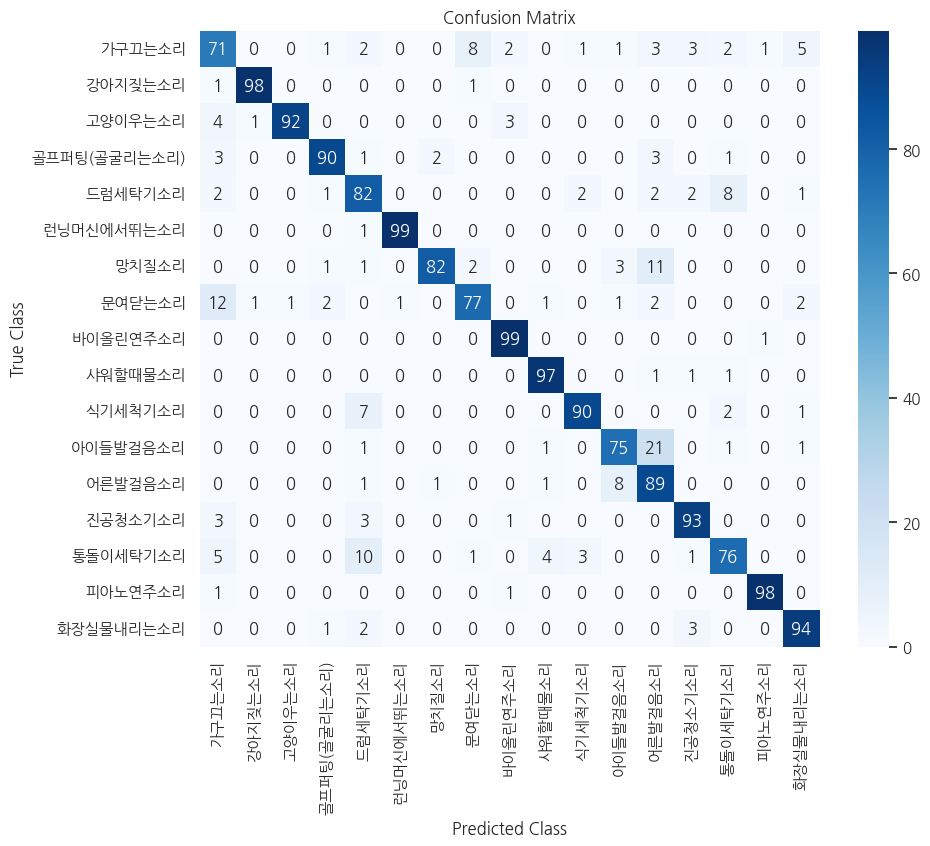

In [9]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# seaborn 한글 폰트 설정
sns.set_theme(font='NanumGothic')

# 모델 로드
model = mobilenet_v2_mfcc(num_classes=num_classes)
model.load_state_dict(torch.load('model/best_mobilenet_mfcc_model.pth'))

model = model.cuda()
model.eval()

# 검증 데이터셋 예측
y_pred = []
y_true = []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# 혼동 행렬 계산
cm = confusion_matrix(y_true, y_pred)

for i in range(len(class_names)):
    if class_names[i] == '강아지짓는소리':
        class_names[i] = '강아지짖는소리'

# 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

In [12]:
from sklearn.metrics import f1_score

# F1 스코어 계산
f1 = f1_score(y_true, y_pred, average='macro')
print(f'F1 Score: {f1:.4f}')


F1 Score: 0.8843


In [13]:
class_names

['가구끄는소리',
 '강아지짖는소리',
 '고양이우는소리',
 '골프퍼팅(골굴리는소리)',
 '드럼세탁기소리',
 '런닝머신에서뛰는소리',
 '망치질소리',
 '문여닫는소리',
 '바이올린연주소리',
 '샤워할때물소리',
 '식기세척기소리',
 '아이들발걸음소리',
 '어른발걸음소리',
 '진공청소기소리',
 '통돌이세탁기소리',
 '피아노연주소리',
 '화장실물내리는소리']